# 2412114101-徐鑫-24软件工程1班


# 猎聘招聘薪资聚类分析与可视化
## 项目背景
本项目基于猎聘招聘平台抓取的 Python 相关岗位数据，字段包含职位名称、工作地点、工作经验、学历、公司规模等核心特征，目标是：
1. 通过无监督聚类方法划分不同薪资水平与能力要求的岗位人群；
2. 提炼影响薪资和岗位层级的关键因素（经验、学历、公司规模等）；
3. 为求职者和用人单位提供分层次、可视化的岗位薪资参考。
## 数据集信息
数据源: data 目录下多份 job_data*.csv（城市 + 关键字切片数据）
清洗后总数据量: 约 400+ 条记录，包含薪资、经验、学历、公司规模等字段
## 关键字段说明（与 CSV 列名对应）
| 字段名称         | 字段类型 | 含义说明                          |
|------------------|----------|-----------------------------------|
| name             | 分类     | 职位名称                          |
| company          | 分类     | 公司名称                          |
| place            | 分类     | 工作地点                          |
| salary           | 文本     | 原始薪资范围（如"20-30k·14薪"） |
| education        | 分类     | 学历要求（如"本科"、"大专"）   |
| experience       | 分类     | 工作经验要求（如"3-5年"）      |
| scale            | 分类     | 公司规模（如"500-999人"）      |
| salary_avg       | 数值     | 解析后的平均月薪(k/月)           |
| experience_years | 数值     | 解析后的工作经验年数             |
| education_level  | 数值     | 学历等级编码                     |
| scale_value      | 数值     | 公司规模等级编码                 |


## 第一阶段:导入库 + 环境配置

In [7]:

# 基础数据处理库 导入建模所需的核心库，配置运行环境，忽略无关警告，为后续建模提供基础。
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import glob
import re
import warnings
import os

warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimSun', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")


环境配置完成！


## 第二阶段:数据采集
### 说明：通过爬取猎聘招聘网站的数据，将不同城市与关键字的职位数据保存为多个 job_data*.csv 文件，在此阶段完成多文件合并与基础去重。


### 2.1 爬虫数据采集（项目内部爬虫模块）

本项目已在 Django 后端中实现了基于 Selenium 的自动化爬虫 `lieSpider()`，用于从猎聘网采集职位数据并自动导出到 data/ 目录下的 CSV 文件。下面的代码演示如何在 Notebook 中直接调用该爬虫模块完成数据采集。


In [8]:
import os
import django
import time

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "JobRecommend.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from job.tools import lieSpider

print("🕷️ 启动爬虫采集示例...")
print("=" * 80)
print("配置：")
print("  关键词: 大数据")
print("  城市: 北京")
print("  页数: 1")
print("\n⏳ 执行中，预计需要 30-60 秒...\n")

start_time = time.time()

try:
    result = lieSpider(
        key_word="Python",
        city="北京",
        all_page="1",
    )
    elapsed = time.time() - start_time
    print("\n" + "=" * 80)
    print("✅ 爬虫执行完成！")
    print(f"⏱️  耗时: {elapsed:.2f} 秒")
    print(f"📊 返回状态: {result}")
    print("\n💾 数据已写入数据库及 data/ 目录下的 CSV 文件")
except Exception as e:
    print(f"\n❌ 爬虫执行出错: {e}")
    print("请检查：")
    print("  1. 浏览器驱动与浏览器版本是否匹配")
    print("  2. 网络连接是否正常")
    print("  3. 数据库连接配置是否正确")


🕷️ 启动爬虫采集示例...
配置：
  关键词: 大数据
  城市: 北京
  页数: 1

⏳ 执行中，预计需要 30-60 秒...

[08:21:48] [INFO] ========== 爬虫任务启动 ==========
[08:21:48] [INFO] 搜索关键词: Python
[08:21:48] [INFO] 目标城市: 北京
[08:21:48] [INFO] 爬取页数: 1
[08:21:48] [INFO] 生成待爬取链接数: 1
[08:21:48] [INFO]   链接1: https://www.liepin.com/zhaopin/?city=010&dqs=010&key=Python&currentPage=1
[08:21:48] [INFO] 开始多线程爬取，线程池大小: 3
[08:21:48] [INFO] [页面1] 开始爬取...
[08:21:54] [INFO] [页面1] 职位列表已加载
[08:22:08] [INFO] [页面1] 解析数据: 职位=42, 薪资=42, 公司=42
[08:22:08] [SUCCESS] [页面1] 成功获取 42 条职位数据
[08:22:29] [INFO] [页面1] 42 条数据已存在（全部重复，已更新）
[08:22:35] [INFO] 成功导出 42 条数据到 job_data_Python_北京_20260112_082235.csv
[08:22:35] [SUCCESS] 数据已导出到CSV: D:\Python\Python_Path\src\JobRecommend_server\data\job_data_Python_北京_20260112_082235.csv
[08:22:35] [SUCCESS] ========== 爬虫任务完成 ==========

✅ 爬虫执行完成！
⏱️  耗时: 47.79 秒
📊 返回状态: 0

💾 数据已写入数据库及 data/ 目录下的 CSV 文件


In [9]:
from displayfunction import display

# 1. 加载与合并数据
print("正在扫描 data/ 目录下的 CSV 文件...")
# 注意：这里我们假设 notebook 在项目根目录，数据在 data/ 子目录
csv_files = glob.glob('data/job_data*.csv')

if not csv_files:
    print("❌ 未找到 CSV 文件！请检查 data/ 目录下是否存在 job_data 开头的文件。")
    # 尝试在当前目录查找 (以防万一)
    csv_files = glob.glob('job_data*.csv')
    if csv_files:
        print(f"⚠️ 在当前目录下找到 {len(csv_files)} 个文件，使用当前目录文件。")

if not csv_files:
    print("❌ 最终未找到任何数据文件。")
else:
    print(f"找到 {len(csv_files)} 个文件: {csv_files}")
    
    df_list = []
    for file in csv_files:
        try:
            temp_df = pd.read_csv(file, encoding='utf-8-sig')
            df_list.append(temp_df)
        except Exception as e:
            print(f"⚠️ 读取 {file} 失败: {e}")
            
    if df_list:
        df = pd.concat(df_list, ignore_index=True)
        # 去重
        original_len = len(df)
        df.drop_duplicates(inplace=True)
        print(f"✅ 数据合并完成! 总行数: {original_len} -> 去重后: {len(df)}")
        print(f"包含列: {df.columns.tolist()}")
        display(df.head())
    else:
        print("❌ 无法加载任何数据。")


正在扫描 data/ 目录下的 CSV 文件...
找到 19 个文件: ['data\\job_data_AI_成都_20260108_004357.csv', 'data\\job_data_cleaned_all.csv', 'data\\job_data_merged_clustered.csv', 'data\\job_data_Python_北京_20251221_165703.csv', 'data\\job_data_Python_北京_20251221_171651.csv', 'data\\job_data_Python_北京_20251222_082512.csv', 'data\\job_data_Python_北京_20251222_082515.csv', 'data\\job_data_Python_北京_20251223_091140.csv', 'data\\job_data_Python_北京_20251223_164437.csv', 'data\\job_data_Python_北京_20251226_113148.csv', 'data\\job_data_Python_北京_20260109_103815.csv', 'data\\job_data_Python_北京_20260109_113741.csv', 'data\\job_data_Python_北京_20260109_113947.csv', 'data\\job_data_Python_北京_20260112_080956.csv', 'data\\job_data_Python_北京_20260112_082235.csv', 'data\\job_data_物联网_北京_20251221_164632.csv', 'data\\job_data_物联网_北京_20251221_165152.csv', 'data\\job_data_物联网_北京_20251221_165454.csv', 'data\\job_data_物联网_西安_20251221_165541.csv']
✅ 数据合并完成! 总行数: 4197 -> 去重后: 2079
包含列: ['name', 'company', 'place', 'salary', 'education',

## 第三阶段:数据预处理
### 数据清洗：
    1. 去除重复记录、过滤无法解析薪资的样本；
    2. 将文本薪资解析为数值平均薪资(salary_avg)；
    3. 将经验、学历、公司规模等字段转换为数值特征(experience_years、education_level、scale_value)。


In [10]:

# 2. 数据清洗与解析
print("\n开始数据清洗...")

def parse_salary(salary_str):
    """解析薪资字符串，返回平均薪资(k)"""
    if pd.isna(salary_str):
        return np.nan
    
    # 处理 "15-30k", "15-30k·14薪" 等格式
    match = re.search(r'(\d+)-(\d+)k', str(salary_str).lower())
    if match:
        low = float(match.group(1))
        high = float(match.group(2))
        return (low + high) / 2
    
    # 处理 "20k" 这种单值
    match_single = re.search(r'(\d+)k', str(salary_str).lower())
    if match_single:
        return float(match_single.group(1))
        
    return np.nan

def parse_experience(exp_str):
    """解析经验字符串，返回数值(年)"""
    if pd.isna(exp_str):
        return 0
    
    exp_str = str(exp_str)
    if '经验不限' in exp_str or '应届' in exp_str:
        return 0.5
    
    # "3-5年" -> 4
    match = re.search(r'(\d+)-(\d+)年', exp_str)
    if match:
        return (float(match.group(1)) + float(match.group(2))) / 2
    
    # "X年"
    match_single = re.search(r'(\d+)年', exp_str)
    if match_single:
        return float(match_single.group(1))
        
    return 1 # 默认值

def parse_education(edu_str):
    """解析学历，返回等级数值"""
    edu_map = {
        '博士': 5,
        '硕士': 4,
        '统招本科': 3,
        '本科': 3,
        '大专': 2,
        '中专': 1,
        '高中': 1,
        '学历不限': 0
    }
    for key, val in edu_map.items():
        if str(edu_str) in key or key in str(edu_str):
            return val
    return 0

# 应用解析
if 'df' in locals():
    df_clean = df.copy()

    # 薪资清洗
    df_clean['salary_avg'] = df_clean['salary'].apply(parse_salary)

    # 经验清洗
    df_clean['experience_years'] = df_clean['experience'].apply(parse_experience)

    # 学历清洗
    df_clean['education_level'] = df_clean['education'].apply(parse_education)

    # 公司规模清洗 (简单映射)
    def parse_scale(scale_str):
        if pd.isna(scale_str): return 0
        if '10000' in str(scale_str): return 5
        if '1000-9999' in str(scale_str): return 4
        if '500-999' in str(scale_str): return 3
        if '100-499' in str(scale_str): return 2
        if '20-99' in str(scale_str): return 1
        return 0

    df_clean['scale_value'] = df_clean['scale'].apply(parse_scale)

    # 删除无法解析薪资的行
    df_clean = df_clean.dropna(subset=['salary_avg'])

    print(f"清洗后剩余数据: {len(df_clean)}")
    display(df_clean[['name', 'salary', 'salary_avg', 'experience', 'experience_years', 'education', 'education_level']].head())

    # 保存清洗后的全量数据
    # 确保 data 目录存在
    if not os.path.exists('data'):
        os.makedirs('data')
        
    clean_output = 'data/job_data_cleaned_all.csv'
    df_clean.to_csv(clean_output, index=False, encoding='utf-8-sig')
    print(f"✅ 已保存: {clean_output}")
else:
    print("❌ df 变量不存在，请检查上一步数据加载是否成功。")



开始数据清洗...
清洗后剩余数据: 2056
name
salary
salary_avg
experience
experience_years
education
education_level
✅ 已保存: data/job_data_cleaned_all.csv


## 第四阶段:数据分析
### 主要分析思路：
    1. 基于清洗后的 salary_avg、experience_years、education_level、scale_value 等字段构建综合特征；
    2. 通过特征工程构造薪资/经验比等业务相关衍生特征；
    3. 为后续 KMeans 聚类建模提供可解释的特征空间。


## 第五阶段：数据建模与挖掘
### 5.1 问题定义：基于 KMeans 的岗位薪资聚类

采用 KMeans 聚类算法，在无标签条件下将岗位按照薪资水平、经验要求、学历要求、公司规模等多维特征划分为若干簇，并通过评估指标与可视化方式解释不同簇的群体特征。


In [11]:

# 3. 高级聚类分析模块

# --- 核心类定义: 配置与特征工程 ---

class Config:
    """配置参数类"""
    # K-means参数
    MAX_K = 10
    RANDOM_STATE = 42
    N_INIT = 10
    MAX_ITER = 300
    
    # 特征列表
    # 基础特征: salary_avg, education_level, experience_years, scale_value
    
    FINAL_FEATURES = [
        'salary_avg',
        'education_level',
        'experience_years',
        'scale_value',
        'salary_per_exp',
        'edu_exp_interaction'
    ]
    
    # 业务指标用于后续评估
    BUSINESS_METRICS = [
        'salary_avg',
        'experience_years',
        'education_level',
        'scale_value'
    ]

class FeatureEngineer:
    """特征工程模块"""

    def __init__(self, config):
        self.config = config
        self.features = None
        self.feature_names = []

    def extract_features(self, df):
        """特征提取与构建"""
        print("\n" + "=" * 60)
        print("步骤: 特征工程")
        print("=" * 60)

        features_df = df.copy()
        
        # 构建衍生特征
        print("构建衍生特征...")
        # 薪资经验比 (经验为0时按0.5年计算)
        exp_safe = features_df['experience_years'].replace(0, 0.5) 
        features_df['salary_per_exp'] = features_df['salary_avg'] / exp_safe
        
        # 学历经验交互项
        features_df['edu_exp_interaction'] = features_df['education_level'] * features_df['experience_years']
        
        print(f"    新增特征: salary_per_exp, edu_exp_interaction")

        # 选择最终特征
        self._select_features(features_df)
        return self.features

    def _select_features(self, df):
        """选择并准备最终特征矩阵"""
        available_features = [f for f in self.config.FINAL_FEATURES if f in df.columns]
        self.feature_names = available_features
        self.features = df[available_features].fillna(0)
        print(f"    最终用于聚类的特征: {self.feature_names}")
        print(f"    特征矩阵形状: {self.features.shape}")

class DataPreprocessor:
    """数据预处理模块"""

    def __init__(self):
        self.scaler = None
        self.features_scaled = None

    def preprocess(self, features):
        """数据预处理与标准化"""
        print("\n" + "=" * 60)
        print("步骤: 数据预处理")
        print("=" * 60)

        # 异常值处理
        features = features.replace([float('inf'), float('-inf')], float('nan'))
        features = features.fillna(features.mean())

        # 标准化
        print("    执行数据标准化 (StandardScaler)...")
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(features)
        self.scaler = scaler
        
        return self.features_scaled

# --- 核心类定义: K-Means 模型 ---

class KMeansModel:
    """K-means模型模块"""

    def __init__(self, config):
        self.config = config
        self.kmeans_model = None
        self.best_k = None
        self.cluster_labels = None
        self.cluster_centers = None

    def find_optimal_k(self, features_scaled, max_k=None):
        """寻找最佳聚类数"""
        if max_k is None:
            max_k = self.config.MAX_K

        print("\n" + "=" * 60)
        print("步骤: 寻找最佳 K 值")
        print("=" * 60)
        
        inertias = []
        silhouette_scores = []
        ch_scores = []
        db_scores = []
        
        k_range = range(2, max_k + 1)

        for k in k_range:
            # 运行 K-Means
            kmeans = KMeans(n_clusters=k, random_state=self.config.RANDOM_STATE, n_init=self.config.N_INIT)
            labels = kmeans.fit_predict(features_scaled)
            
            # 计算指标
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(features_scaled, labels))
            ch_scores.append(calinski_harabasz_score(features_scaled, labels))
            db_scores.append(davies_bouldin_score(features_scaled, labels))
            
            print(f"K={k}: 轮廓系数={silhouette_scores[-1]:.4f}, CH指数={ch_scores[-1]:.1f}, DB指数={db_scores[-1]:.4f}")

        # 综合建议 K 值 (这里简单使用轮廓系数最大的 K)
        best_silhouette_k = k_range[np.argmax(silhouette_scores)]
        print(f"\n✅ 轮廓系数建议最佳 K 值: {best_silhouette_k}")
        
        # 绘制评估图
        self._plot_metrics(k_range, inertias, silhouette_scores, ch_scores, db_scores)
        
        self.best_k = best_silhouette_k
        return self.best_k

    def _plot_metrics(self, k_range, inertias, silhouette, ch, db):
        """绘制评估指标图"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        axes[0,0].plot(k_range, inertias, 'go-')
        axes[0,0].set_title('肘部法则 (Inertia)')
        axes[0,0].set_xlabel('K')
        
        axes[0,1].plot(k_range, silhouette, 'bo-')
        axes[0,1].set_title('轮廓系数 (Silhouette)')
        axes[0,1].set_xlabel('K')
        
        axes[1,0].plot(k_range, ch, 'ro-')
        axes[1,0].set_title('Calinski-Harabasz 指数')
        axes[1,0].set_xlabel('K')
        
        axes[1,1].plot(k_range, db, 'mo-')
        axes[1,1].set_title('Davies-Bouldin 指数')
        axes[1,1].set_xlabel('K')
        
        plt.tight_layout()
        plt.show()

    def build_model(self, features_scaled, n_clusters=None):
        """构建最终模型"""
        if n_clusters is None:
            n_clusters = self.best_k
            
        print(f"\n使用 K={n_clusters} 构建最终模型...")
        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=self.config.RANDOM_STATE, n_init=self.config.N_INIT)
        self.cluster_labels = self.kmeans_model.fit_predict(features_scaled)
        self.cluster_centers = self.kmeans_model.cluster_centers_
        
        return self.kmeans_model

# --- 核心类定义: 评估与可视化 ---

class Evaluator:
    """评估模块"""

    def __init__(self, config):
        self.config = config

    def evaluate(self, features_scaled, cluster_labels, df):
        """评估聚类结果"""
        print("\n" + "=" * 60)
        print("步骤: 模型评估")
        print("=" * 60)

        # 1. 内部指标 (Silhouette)
        sil = silhouette_score(features_scaled, cluster_labels)
        print(f"最终轮廓系数: {sil:.4f}")
        
        if sil > 0.5:
            print("✅ 聚类结构清晰")
        elif sil > 0.3:
            print("⚠️ 聚类结构一般")
        else:
            print("❌ 聚类结构较弱")

        # 2. 业务指标统计
        df_eval = df.copy()
        df_eval['cluster'] = cluster_labels
        
        print("\n各聚类业务指标均值:")
        # 确保只使用存在的列
        metrics = [col for col in self.config.BUSINESS_METRICS if col in df_eval.columns]
        summary = df_eval.groupby('cluster')[metrics].mean()
        print(summary)
        
        return summary

class Visualizer:
    """可视化模块"""
    
    def __init__(self, config):
        self.config = config
    
    def plot_results(self, df, features_scaled, cluster_labels, feature_names):
        """生成综合可视化图表"""
        print("\n" + "=" * 60)
        print("步骤: 结果可视化")
        print("=" * 60)
        
        # 1. PCA 降维散点图
        self._plot_pca(features_scaled, cluster_labels)
        
        # 2. 特征箱线图
        self._plot_boxplots(df, cluster_labels)
        
        # 3. 聚类中心雷达图
        self._plot_radar(df, cluster_labels, feature_names)

    def _plot_pca(self, features_scaled, cluster_labels):
        """PCA 2D 可视化"""
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(features_scaled)
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=100, alpha=0.8)
        plt.title(f'PCA 降维聚类可视化 (解释方差比: {sum(pca.explained_variance_ratio_):.2f})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True, alpha=0.3)
        plt.show()
        
    def _plot_boxplots(self, df, labels):
        """绘制关键特征的箱线图"""
        df_plot = df.copy()
        df_plot['cluster'] = labels
        
        metrics = self.config.BUSINESS_METRICS
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(1, n_metrics, figsize=(4*n_metrics, 5))
        if n_metrics == 1: axes = [axes]
        
        for i, metric in enumerate(metrics):
            if metric in df_plot.columns:
                sns.boxplot(x='cluster', y=metric, data=df_plot, ax=axes[i], palette='viridis')
                axes[i].set_title(f'{metric} 分布')
        
        plt.tight_layout()
        plt.show()
        
    def _plot_radar(self, df, labels, feature_names):
        """绘制聚类中心雷达图"""
        # 注意：需要归一化数据绘制雷达图才直观
        df_plot = df.copy()
        df_plot['cluster'] = labels
        
        # 计算每个聚类的均值
        metrics = [f for f in self.config.FINAL_FEATURES if f in df_plot.columns]
        means = df_plot.groupby('cluster')[metrics].mean()
        
        # Min-Max 归一化用于绘图
        scaler = MinMaxScaler()
        means_normalized = pd.DataFrame(scaler.fit_transform(means), columns=means.columns, index=means.index)
        
        # 绘图要闭合
        labels_loc = np.linspace(start=0, stop=2 * np.pi, num=len(metrics), endpoint=False).tolist()
        labels_loc += [labels_loc[0]]  # 闭合
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, polar=True)
        
        for i, row in means_normalized.iterrows():
            values = row.tolist()
            values += [values[0]]
            ax.plot(labels_loc, values, label=f'Cluster {i}')
            ax.fill(labels_loc, values, alpha=0.25)
            
        ax.set_thetagrids(np.degrees(labels_loc[:-1]), metrics)
        plt.title('各聚类特征雷达图 (归一化)')
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.show()

class ClusterInterpreter:
    """解释模块"""
    
    def interpret(self, df, cluster_labels, features_scaled, feature_names):
        """自动解释聚类特征"""
        print("\n" + "=" * 60)
        print("步骤: 聚类结果解读")
        print("=" * 60)
        
        df_analysis = df.copy()
        df_analysis['cluster'] = cluster_labels
        
        n_clusters = len(df_analysis['cluster'].unique())
        
        # 计算全局均值用于对比
        global_means = df_analysis[['salary_avg', 'experience_years', 'education_level']].mean()
        
        for i in range(n_clusters):
            cluster_data = df_analysis[df_analysis['cluster'] == i]
            size = len(cluster_data)
            
            # 计算该聚类的核心特征
            c_salary = cluster_data['salary_avg'].mean()
            c_exp = cluster_data['experience_years'].mean()
            c_edu = cluster_data['education_level'].mean()
            
            # 生成标签逻辑
            tags = []
            if c_salary > global_means['salary_avg'] * 1.2:
                tags.append("高薪")
            elif c_salary < global_means['salary_avg'] * 0.8:
                tags.append("低薪")
            else:
                tags.append("中等薪资")
                
            if c_exp > global_means['experience_years'] * 1.2:
                tags.append("资深")
            elif c_exp < global_means['experience_years'] * 0.8:
                tags.append("初级")
            else:
                tags.append("中级经验")
                
            label = " ".join(tags) + "群体"
            
            print(f"\n📊 聚类 {i} ({label}):")
            print(f"   样本数: {size}")
            print(f"   平均薪资: {c_salary:.1f}k")
            print(f"   平均经验: {c_exp:.1f}年")
            print(f"   平均学历等级: {c_edu:.1f}")


## 第六阶段:数据可视化
### 在本阶段中，结合聚类结果输出多种可视化图表（PCA 降维散点图、关键特征箱线图、聚类中心雷达图），并对不同聚类人群进行业务解读与结果落地（带聚类标签的数据导出）。



步骤: 特征工程
构建衍生特征...
    新增特征: salary_per_exp, edu_exp_interaction
    最终用于聚类的特征: ['salary_avg', 'education_level', 'experience_years', 'scale_value', 'salary_per_exp', 'edu_exp_interaction']
    特征矩阵形状: (2056, 6)

步骤: 数据预处理
    执行数据标准化 (StandardScaler)...

步骤: 寻找最佳 K 值
K=2: 轮廓系数=0.2886, CH指数=811.4, DB指数=1.3542
K=3: 轮廓系数=0.2992, CH指数=789.3, DB指数=1.2533
K=4: 轮廓系数=0.3259, CH指数=748.4, DB指数=1.0702
K=5: 轮廓系数=0.3296, CH指数=753.8, DB指数=1.0847
K=6: 轮廓系数=0.3520, CH指数=799.9, DB指数=0.9544
K=7: 轮廓系数=0.3426, CH指数=815.4, DB指数=0.9966
K=8: 轮廓系数=0.3413, CH指数=820.9, DB指数=0.9848
K=9: 轮廓系数=0.3467, CH指数=804.0, DB指数=0.9369
K=10: 轮廓系数=0.3493, CH指数=809.4, DB指数=0.9273

✅ 轮廓系数建议最佳 K 值: 6


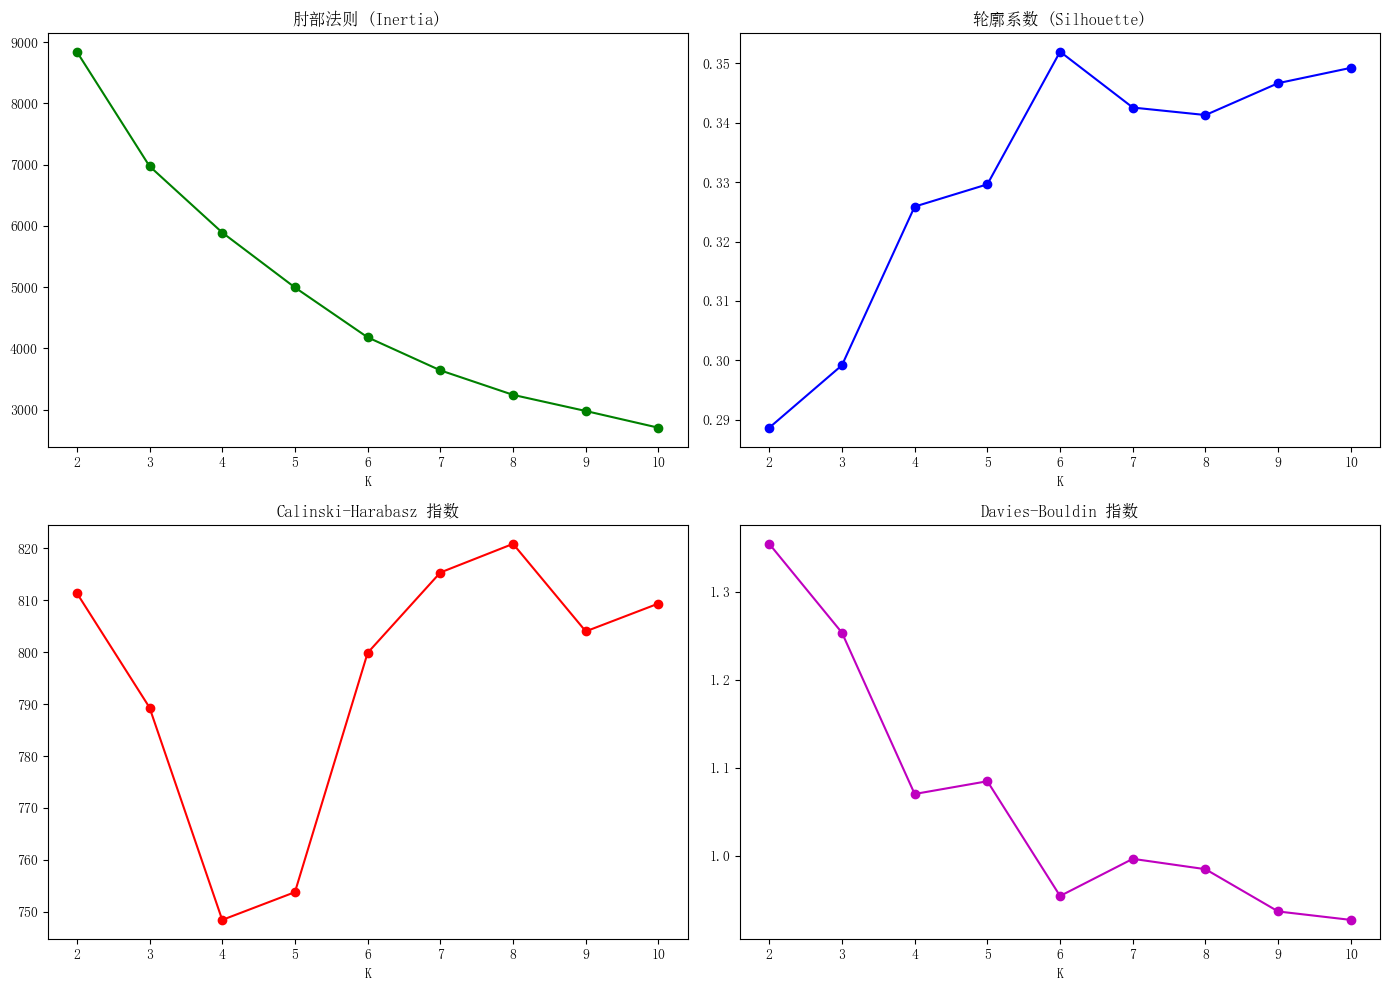


使用 K=6 构建最终模型...

步骤: 模型评估
最终轮廓系数: 0.3520
⚠️ 聚类结构一般

各聚类业务指标均值:
         salary_avg  experience_years  education_level  scale_value
cluster                                                            
0         30.222222          3.462963         0.000000     2.518519
1         32.616279          5.784884         3.246512     4.265116
2         35.824042          0.500000         3.181185     2.355401
3         28.514706          8.080882         2.838235     0.573529
4         20.023691          2.730050         2.830424     0.639651
5        111.250000          7.125000         3.500000     2.375000

步骤: 结果可视化


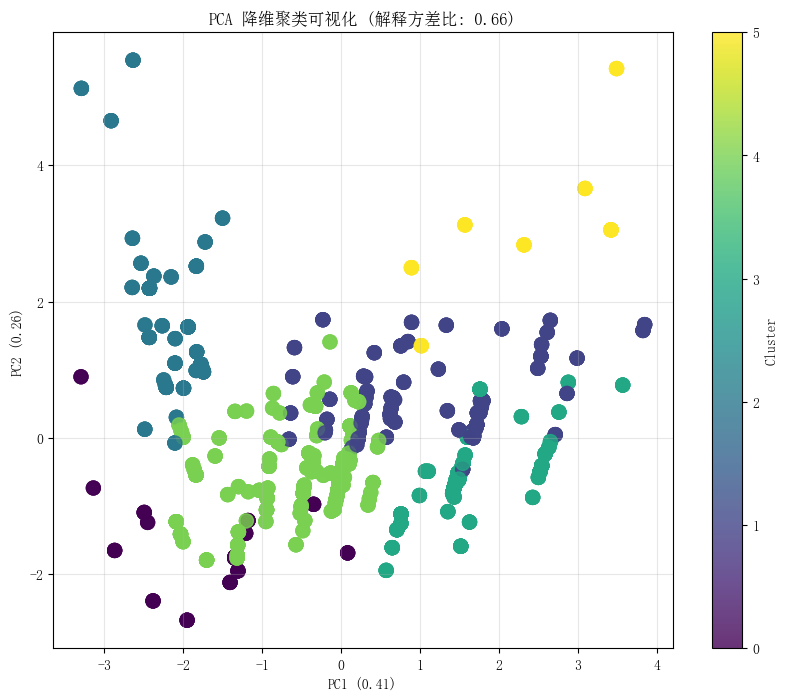

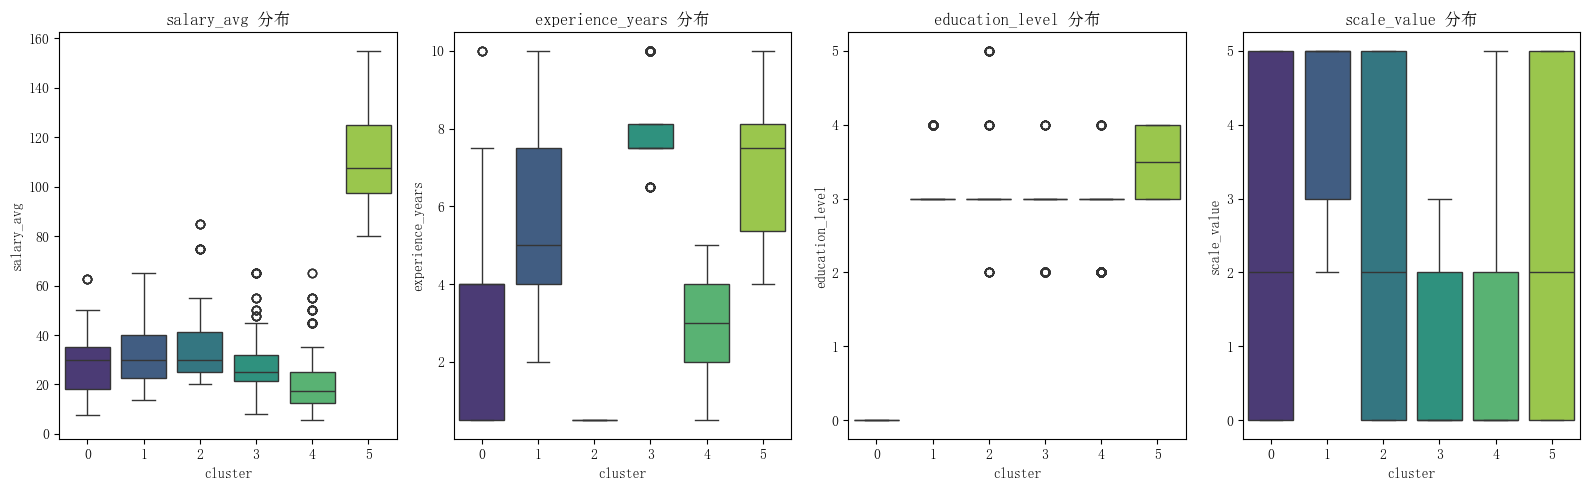

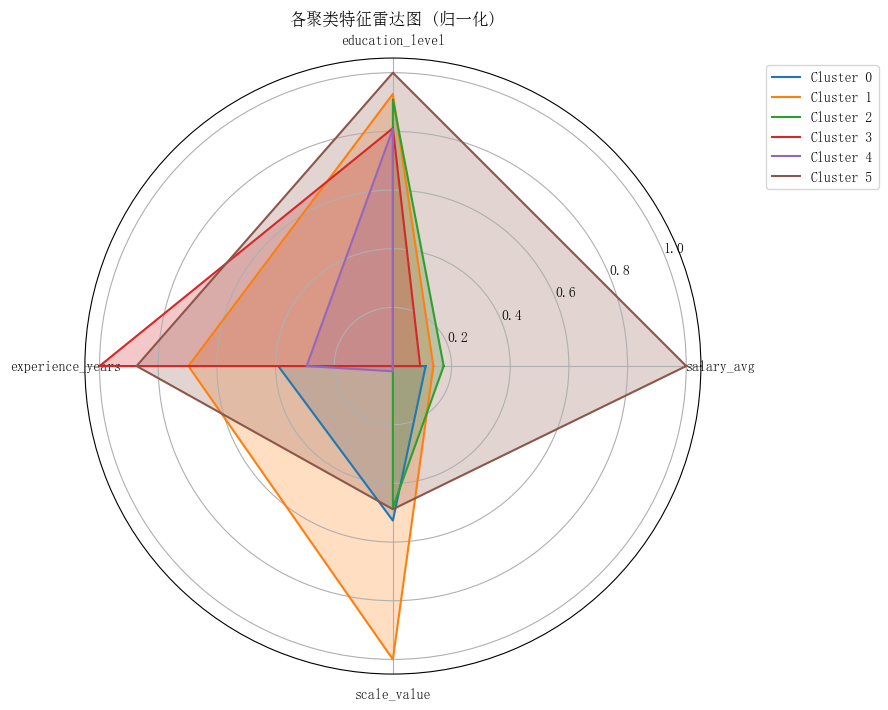


步骤: 聚类结果解读

📊 聚类 0 (中等薪资 中级经验群体):
   样本数: 81
   平均薪资: 30.2k
   平均经验: 3.5年
   平均学历等级: 0.0

📊 聚类 1 (中等薪资 资深群体):
   样本数: 430
   平均薪资: 32.6k
   平均经验: 5.8年
   平均学历等级: 3.2

📊 聚类 2 (高薪 初级群体):
   样本数: 287
   平均薪资: 35.8k
   平均经验: 0.5年
   平均学历等级: 3.2

📊 聚类 3 (中等薪资 资深群体):
   样本数: 408
   平均薪资: 28.5k
   平均经验: 8.1年
   平均学历等级: 2.8

📊 聚类 4 (低薪 初级群体):
   样本数: 802
   平均薪资: 20.0k
   平均经验: 2.7年
   平均学历等级: 2.8

📊 聚类 5 (高薪 资深群体):
   样本数: 48
   平均薪资: 111.2k
   平均经验: 7.1年
   平均学历等级: 3.5

✅ 最终带标签数据已保存: data/job_data_merged_clustered.csv


In [12]:

# 4. 执行分析流程

# 初始化配置与对象
config = Config()
feature_engineer = FeatureEngineer(config)
preprocessor = DataPreprocessor()
kmeans_model = KMeansModel(config)
evaluator = Evaluator(config)
visualizer = Visualizer(config)
interpreter = ClusterInterpreter()

# 执行
if 'df_clean' in locals():
    features = feature_engineer.extract_features(df_clean)
    features_scaled = preprocessor.preprocess(features)
    best_k = kmeans_model.find_optimal_k(features_scaled)
    model = kmeans_model.build_model(features_scaled, n_clusters=best_k)

    # 评估
    evaluator.evaluate(features_scaled, kmeans_model.cluster_labels, df_clean)
    
    # 可视化 (新增)
    visualizer.plot_results(df_clean, features_scaled, kmeans_model.cluster_labels, feature_engineer.feature_names)
    
    # 解释
    interpreter.interpret(df_clean, kmeans_model.cluster_labels, features_scaled, feature_engineer.feature_names)

    # 保存最终结果 (合并 + 聚类标签)
    df_clean['cluster'] = kmeans_model.cluster_labels
    
    if not os.path.exists('data'):
        os.makedirs('data')
        
    final_output = 'data/job_data_merged_clustered.csv'
    df_clean.to_csv(final_output, index=False, encoding='utf-8-sig')
    print(f"\n✅ 最终带标签数据已保存: {final_output}")
else:
    print("❌ df_clean 变量不存在，无法执行分析流程。")
